# Looking for single nucleotide effects
The effects of single nucleotide changes are measured by merging two related datasets and calculating correlations between readnumbers of sequecnes which have the same base at the same position.
- Get all of the sequences that are present in both datasets, that have a base B at position P. Calculate the correlation between their read numbers in the two datasets.
- Do this for all of the positions, for all of the bases, setting a threshold on the p-value.
- In the case of running this analysis for a combination of positions, find the largest absolute value of a difference in the r coefficient (in the case of a small enough p-value) and report this. 
- Sort by decreasing r coefficient maximum difference.
- Visualize top couple of combinations, try to explain the effect with the smallest possible number of positions.

In [1]:
import pandas as pd
from ivstools import tools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
from itertools import combinations

In [2]:
# matplotlib settings
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 13
#plt.rcParams['font.family'] = 'Arial'

In [3]:
dataset1 = '/home/kurfurst/Documents/datasets/MV_aurora_singlestep_100sec_100uM.tsv'
dname1 = 'kcat'

dataset2 = '/home/kurfurst/Documents/datasets/MV_aurora_singlestep_10min_20uM.tsv'
dname2 = 'Km'

p_value_threshold = 0.01
topN = 1000

aurora_secstruct_positions = tools.aurora_secstuct_positions 
# [4,6,11,12,14,15,16,17,22,23,26,27,28,29,30,34,37,40,42,43,44,45,46,47]

positions = [x - 1 for x in aurora_secstruct_positions]
position_combinations = list(combinations(positions, r=2))

In [4]:
# Read datasets

countcol1 = 'count_' + dname1
countcol2 = 'count_' + dname2

df_main_1 = pd.read_csv(dataset1, sep='\t', names=[countcol1, 'seq'])
df_main_2 = pd.read_csv(dataset2, sep='\t', names=[countcol2, 'seq'])

# Merge datasets
df_merged = df_main_1.merge(df_main_2, how='inner', on='seq')
df_merged = df_merged.head(topN)

In [5]:
def getCorr_p(p, df, ccol1, ccol2):
    
    # get Unique base combinations at given position combination
    bases = set([''.join([s[x] for x in p]) for s in df['seq']])
    
    # Subresults for a given position combinations
    pos_results = []
    
    for b in bases:
        
        df_sub = df.iloc[[True if ''.join([s[px] for px in p]) == b else False for s in df['seq']]] # Subset df
        if len(df_sub) > 5:
            pr, pval = pearsonr(df_sub[ccol1], df_sub[ccol2]) # Compute correlation
            if pval < p_value_threshold:
                pos_results.append([p, pr, pval])
    
    if len(pos_results) <=1 :
        return None
    else:
        maxdiff = max([abs(pos_results[i][1] - pos_results[j][1]) for j in range(0, len(pos_results)) for i in range(j + 1, len(pos_results))])
        return ['-'.join(str(p) for p in p), maxdiff]

In [6]:
corr_table = []
for p_comb in position_combinations:
    p_correlation = getCorr_p(p_comb, df_merged, countcol1, countcol2)
    if p_correlation:
        corr_table.append(p_correlation)

Running this analysis for the top 1000 sequences which are common for the two datasets, doing it for all of the pairwise combinations, I can summarize the results with the following table. It seems like the largest r-difference is found between positions 34-37, 26-34, 30-34 ... but all of these contain a repeating position 34. Another repeating position is 42.

In [7]:
df_corr = pd.DataFrame(corr_table, columns=['p', 'r_diff'])
df_corr['p'] = ['-'.join([str(int(x) + 1) for x in pc.split('-')]) for pc in df_corr['p']]
df_corr.sort_values('r_diff', ascending=False).head(20)

,p,r_diff
195,34-37,0.402136
144,26-34,0.387040
186,30-34,0.362841
26,6-34,0.355014
156,27-34,0.339693
189,30-42,0.319977
177,29-34,0.318709
147,26-42,0.298778
178,29-37,0.281854
204,37-42,0.281001


Below I visualize the effect of position 34, 42 and a couple of the combinations. It seems like position 34 truly has an effect as a single position mutation.

---

In [8]:
cdict = {'A':'blue', 'T':'red', 'G':'green', 'C':'yellow'}

**position 34**

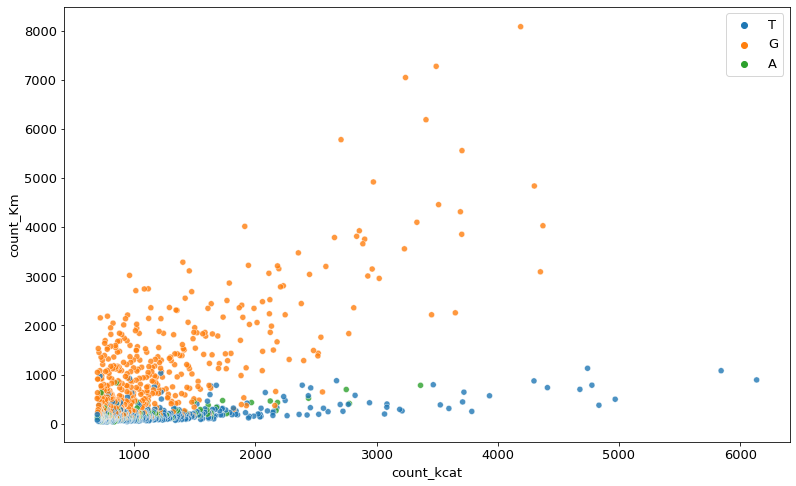

In [9]:
positions = [33]
df_merged['pos'] = [''.join([s[px] for px in positions]) for s in df_merged['seq']]
plt.figure(figsize=(13, 8))
sns.scatterplot(data=df_merged, x=countcol1, y=countcol2, hue='pos', alpha=0.8)
plt.xlabel(countcol1)
plt.ylabel(countcol2)
plt.legend()
plt.show()

**position 42**

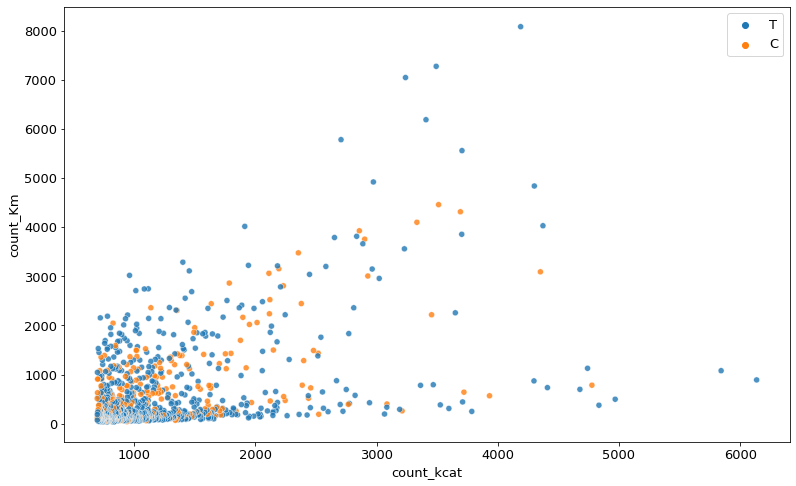

In [10]:
positions = [41]
df_merged['pos'] = [''.join([s[px] for px in positions]) for s in df_merged['seq']]
plt.figure(figsize=(13, 8))
sns.scatterplot(data=df_merged, x=countcol1, y=countcol2, hue='pos', alpha=0.8)
plt.xlabel(countcol1)
plt.ylabel(countcol2)
plt.legend()
plt.show()

**positions 34-37**

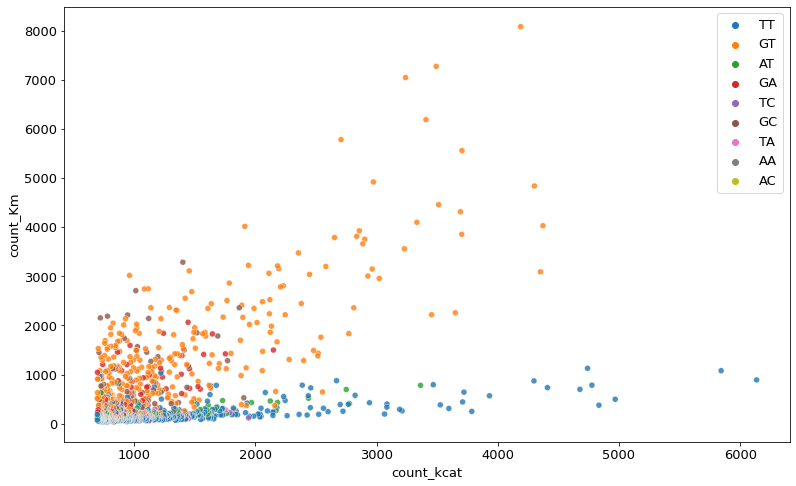

In [11]:
positions = [33, 36]
df_merged['pos'] = [''.join([s[px] for px in positions]) for s in df_merged['seq']]
plt.figure(figsize=(13, 8))
sns.scatterplot(data=df_merged, x=countcol1, y=countcol2, hue='pos', alpha=0.8)
plt.xlabel(countcol1)
plt.ylabel(countcol2)
plt.legend()
plt.show()

**positions 29-37**

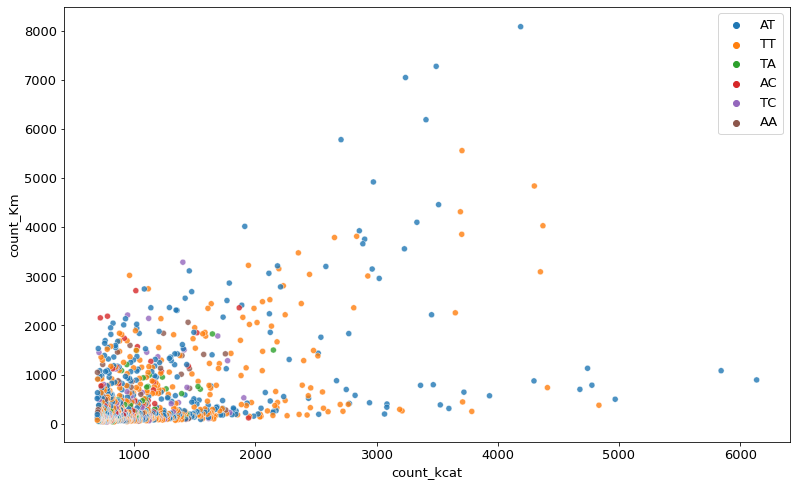

In [12]:
positions = [28, 36]
df_merged['pos'] = [''.join([s[px] for px in positions]) for s in df_merged['seq']]
plt.figure(figsize=(13, 8))
sns.scatterplot(data=df_merged, x=countcol1, y=countcol2, hue='pos', alpha=0.8)
plt.xlabel(countcol1)
plt.ylabel(countcol2)
plt.legend()
plt.show()

In [ ]:
df['pos'] = [''.join([s[px] for px in positions]) for s in df['seq']]
groups = df.groupby('pos')
for base in ['G', 'T', 'A', 'C']:
    try:
        sub = df.loc[groups.groups[base]]
        plt.scatter(sub[countcol1], sub[countcol2], c=cdict[base], alpha=0.4, label=base)
    except:
        pass
plt.legend(title='pos 34')
plt.xlabel(countcol1)
plt.ylabel(countcol2)
#plt.show()
plt.tight_layout()
plt.savefig('position34.png', bbox_inches='tight', dpi=400)